In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import yaml

import dac
from plotting import dict_format

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams.update({'font.size': 12})

<h1>Bandgap</h1>

In [ ]:
fname = '../../data/testing/20220223_132341_bandgap_10800x.csv'

# Reading by rows
df = pd.read_csv(fname, header=None).set_index(0).T

In [ ]:
teensy_vec = np.array(df['Teensy Internal Temp'])
temp_vec = np.array(df['TMP102'])
chamber_vec = np.array(df['Chamber'])
vbg_vec = np.array(df['Bandgap (V)'])

In [ ]:
### Bandgap voltage plotting
plt.scatter(teensy_vec, vbg_vec, alpha=0.5, label='Teensy Internal')
plt.scatter(chamber_vec, vbg_vec, alpha=0.5, label='Chamber Readout')
# plt.scatter(temp_vec, vbg_vec, alpha=0.5, label='TMP102')

plt.legend()
plt.grid(True)
plt.ylabel('Bandgap Voltage (V)');
plt.xlabel('Temperature (C)');

print(f'Bandgap Voltage Range: {max(vbg_vec)-min(vbg_vec)}')

In [ ]:
vbg_hist, vbg_bins_raw = np.histogram(vbg_vec, bins=100)
vbg_bins = 0.5*(vbg_bins_raw[1:] + vbg_bins_raw[:-1])
plt.plot(vbg_bins, vbg_hist)
plt.xlabel('Bandgap Voltage (V)')
plt.ylabel('Count')
plt.grid(True)

In [ ]:
### Temp Comparison Plotting
# Histogram
n_bins = 100

teensy_hist, teensy_bins_raw = np.histogram(teensy_vec, bins=n_bins)
chamber_hist, chamber_bins_raw = np.histogram(chamber_vec, bins=n_bins)
# temp_hist, temp_bins_raw = np.histogram(temp_vec, bins=n_bins)

teensy_bins = 0.5*(teensy_bins_raw[1:] + teensy_bins_raw[:-1])
chamber_bins = 0.5*(chamber_bins_raw[1:] + chamber_bins_raw[:-1])
# temp_bins = 0.5*(temp_bins_raw[1:] + temp_binw_raw[:-1])

plt.plot(teensy_bins, teensy_hist, label='Teensy Internal')
plt.plot(chamber_bins, chamber_hist, label='Chamber Readout')
# plt.plot(temp_bins, temp_hist, label='TMP102')

plt.legend()
plt.grid(True)
plt.xlabel('Temperature (C)')
plt.ylabel('Count')

In [ ]:
# Temp Differences
plt.plot(teensy_vec, label='Teensy Internal')
plt.plot(chamber_vec, label='Chamber Readout')
# plt.plot(temp_vec, label='TMP102')
plt.xlabel('Sample')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(teensy_vec-chamber_vec, label='Teensy Internal - Chamber Readout')
plt.xlabel('Sample')
plt.ylabel('Teensy-Chamber (C)')
plt.grid(True)

In [ ]:
# 

<h1>Resistive DAC</h1>

In [2]:
plt.rcParams['figure.figsize'] = (4,6)
plt.rcParams.update({'font.size': 12})

<h2>INL/DNL</h2>

In [3]:
# fname = '../../data/testing/20220225_135703_dac0_1000x.csv'
fname = '../../data/testing/20220225_151239_dac1_1000x.csv'
num_iter = 1000

# Reading by rows
df = pd.read_csv(fname, header=None, names=['Code']+[f'Iteration {x}' for x in range(1,num_iter+1)])

code_data_dict = dict()
for row in df.itertuples(index=False):
    code = 255-int(row[0]) # Backwards codes, whoops...
    data = row[1:]
    code_data_dict[code] = data

In [14]:
code_max = max(code_data_dict.keys())
code_min = min(code_data_dict.keys())
print(f'Range: {np.mean(code_data_dict[code_min])}, {np.mean(code_data_dict[code_max])}')

Range: 0.274016267138, 1.1512391095119998


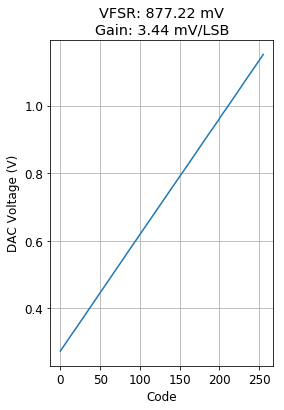

In [4]:
code_vec = code_data_dict.keys()
avg_vec = [np.mean(code_data_dict[code]) for code in code_vec]
gain = dac.calc_gain(code_data_dict)
vfsr = dac.calc_fsr(code_data_dict)

plt.plot(code_vec, avg_vec)
plt.xlabel('Code')
plt.ylabel('DAC Voltage (V)')
plt.grid(True)
plt.title(f'VFSR: {round(vfsr*1e3, 2)} mV\nGain: {round(gain*1e3, 2)} mV/LSB');
# plt.annotate(f'FSR: {vfsr}V\nGain: {gain}V/LSB', (0,0))

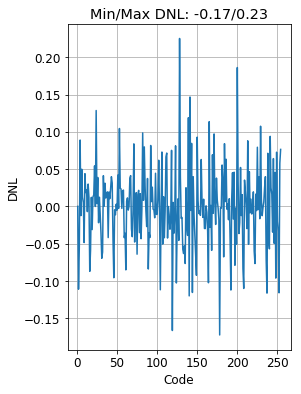

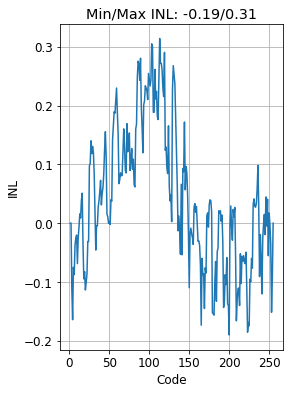

In [5]:
# Plotting DNL and INL
dnl_dict = dac.calc_dnl(code_data_dict)
code_vec, dnl_vec = dict_format(dnl_dict)
plt.plot(code_vec, dnl_vec)
plt.xlabel('Code')
plt.ylabel('DNL')
plt.grid(True)
plt.title(f'Min/Max DNL: {round(min(dnl_vec), 2)}/{round(max(dnl_vec), 2)}');
# plt.axhline(y=-1, color='r', linestyle='-')
# plt.axhline(y=1, color='r', linestyle='-')

plt.figure()
inl_dict = dac.calc_inl(code_data_dict)
code_vec, inl_vec = dict_format(inl_dict)
plt.plot(code_vec, inl_vec)
plt.xlabel('Code')
plt.ylabel('INL')
plt.grid(True)
plt.title(f'Min/Max INL: {round(min(inl_vec), 2)}/{round(max(inl_vec), 2)}');

Text(0.5,1,'Max RMS Noise: 1.17 mV')

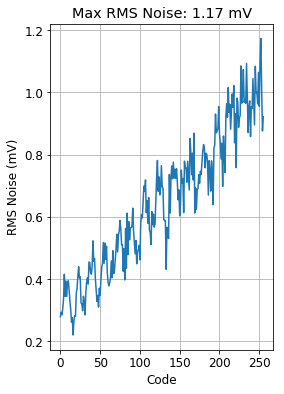

In [13]:
code_noise_dict = dac.calc_noise(code_data_dict)
code_vec, noise_vec = dict_format(code_noise_dict)
plt.plot(code_vec, [1e3*x for x in noise_vec])
plt.xlabel('Code')
plt.ylabel('RMS Noise (mV)')
plt.grid(True)
plt.title(f'Max RMS Noise: {round(max(noise_vec)*1e3, 2)} mV')

<h1>Peak Detector</h1>

In [4]:
file_in = '../../data/testing/20220303_181854_pk_200x.yaml'
with open(file_in, 'r') as f:
    data_dict = yaml.load(f, Loader=yaml.FullLoader)

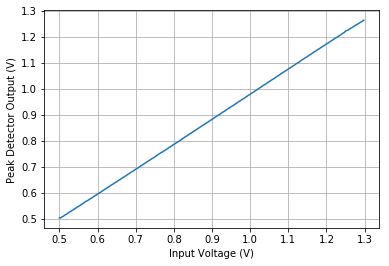

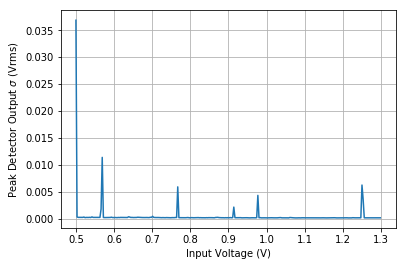

In [22]:
vin_ideal_vec = data_dict['ideal']
vin_real_vec = data_dict['real']
vout_raw = data_dict['output']
vout_avg_vec = [np.mean(vout_vec) for vout_vec in vout_raw]
vout_std_vec = [np.std(vout_vec) for vout_vec in vout_raw]

plt.plot(vin_real_vec, vout_avg_vec)
plt.grid(True)
plt.xlabel('Input Voltage (V)');
plt.ylabel('Peak Detector Output (V)');

plt.figure()
plt.plot(vin_real_vec, vout_std_vec)
plt.grid(True)
plt.xlabel('Input Voltage (V)');
plt.ylabel('Peak Detector Output $\sigma$ (Vrms)');

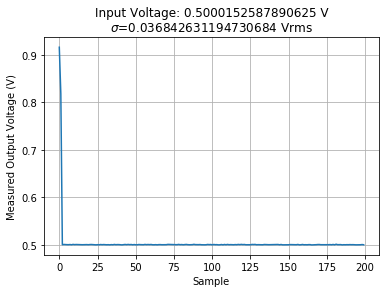

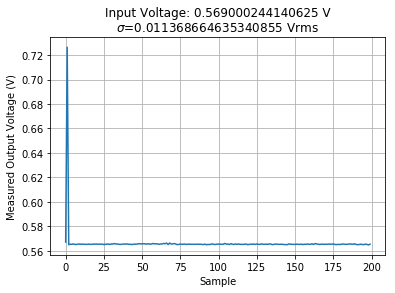

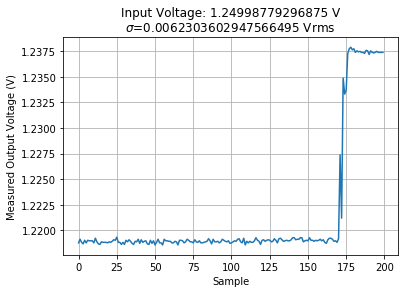

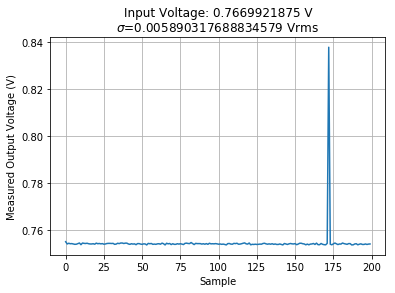

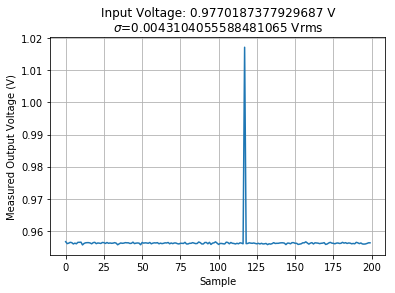

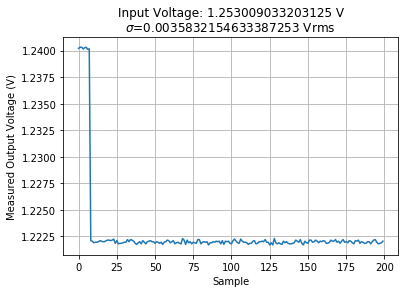

In [34]:
# Looking at conditions with worst standard deviations
idx_max_std_vec = np.argsort(vout_std_vec)[::-1]

for i in range(6):
    idx_std = idx_max_std_vec[i]
    vin = vin_real_vec[idx_std]
    vout_data = vout_raw[idx_std]
    vout_std = vout_std_vec[idx_std]
    
    plt.figure()
    plt.plot(vout_data)
    plt.xlabel('Sample');
    plt.ylabel('Measured Output Voltage (V)');
    plt.title(f'Input Voltage: {vin} V\n$\sigma$={vout_std} Vrms');
    plt.grid(True)